<a href="https://colab.research.google.com/github/Eximmius/Thumbs-Classifier/blob/master/Train_Thumbs_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Thumbs Up/Down Classifier Training
CNN: Mobilnet_V2


### 1 - Download and prepare Dataset

In [1]:
#Download dataset from Github
!rm -r Dataset.zip Dataset # Redownload
!wget Dataset.zip https://github.com/Eximmius/Thumbs-Classifier/raw/master/Dataset.zip
!unzip Dataset.zip
data_root = ('Dataset')

--2020-07-30 17:26:39--  http://dataset.zip/
Resolving dataset.zip (dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘dataset.zip’
--2020-07-30 17:26:39--  https://github.com/Eximmius/Thumbs-Classifier/raw/master/Dataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Eximmius/Thumbs-Classifier/master/Dataset.zip [following]
--2020-07-30 17:26:39--  https://raw.githubusercontent.com/Eximmius/Thumbs-Classifier/master/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13393955 (13M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[

In [2]:
import tensorflow as tf

IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels
TRAINING_DATA_DIR = str(data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
  TRAINING_DATA_DIR,
  subset='validation',
  shuffle=True,
  target_size=IMAGE_SHAPE
  )
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
  TRAINING_DATA_DIR,
  subset='training',
  shuffle=True,
  target_size=IMAGE_SHAPE)

Found 22 images belonging to 2 classes.
Found 89 images belonging to 2 classes.


In [3]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 2))

In [4]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

thumbs_down
thumbs_up

### 2 - Download & compile pre trained classifier 

In [5]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
 hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 
 output_shape=[1280],
 trainable=False),
 tf.keras.layers.Dropout(0.4),
 tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

### 3 - (Re)Train model 

In [7]:
import numpy as np
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
  train_generator, 
  epochs=20,
  verbose=1,
  steps_per_epoch=steps_per_epoch,
  validation_data=valid_generator,
  validation_steps=val_steps_per_epoch).history

Epoch 1/20
3/3 [==============================] - 6s 2s/step - loss: 1.6359 - acc: 0.5281 - val_loss: 0.8482 - val_acc: 0.5455
Epoch 2/20
3/3 [==============================] - 5s 2s/step - loss: 0.8097 - acc: 0.5393 - val_loss: 0.6700 - val_acc: 0.5909
Epoch 3/20
3/3 [==============================] - 5s 2s/step - loss: 0.8772 - acc: 0.5281 - val_loss: 0.6622 - val_acc: 0.5909
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: 0.6631 - acc: 0.5955 - val_loss: 0.4293 - val_acc: 0.7727
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.4763 - acc: 0.7865 - val_loss: 0.3128 - val_acc: 0.9545
Epoch 6/20
3/3 [==============================] - 5s 2s/step - loss: 0.3201 - acc: 0.8427 - val_loss: 0.3510 - val_acc: 0.8182
Epoch 7/20
3/3 [==============================] - 5s 2s/step - loss: 0.3980 - acc: 0.7865 - val_loss: 0.3580 - val_acc: 0.7273
Epoch 8/20
3/3 [==============================] - 6s 2s/step - loss: 0.3230 - acc: 0.8427 - val_loss: 0.2598 - 

In [8]:
#save model
saved_model_path = "saved_thumbs_model.h5"
model.save(saved_model_path)

In [9]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

1/1 [==============================] - 0s 1ms/step - loss: 0.0602 - acc: 1.0000
Final loss: 0.06
Final accuracy: 100.00%


### 4 - Learning Hist

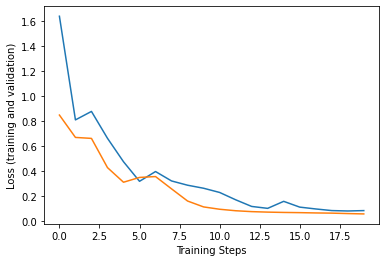

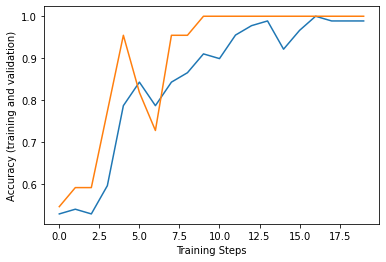

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps')
#plt.ylim([0,1])
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps')
#plt.ylim([0,1])
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

### 5 - Output

In [11]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

tf_model_predictions = model.predict(val_image_batch)
print('Prediction results shape:', tf_model_predictions.shape)

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

Validation batch shape: (22, 224, 224, 3)
['Thumbs_Down' 'Thumbs_Up']
Prediction results shape: (22, 2)
['Thumbs_Up' 'Thumbs_Down' 'Thumbs_Up' 'Thumbs_Up' 'Thumbs_Down'
 'Thumbs_Down' 'Thumbs_Up' 'Thumbs_Up' 'Thumbs_Down' 'Thumbs_Up'
 'Thumbs_Up' 'Thumbs_Down' 'Thumbs_Down' 'Thumbs_Down' 'Thumbs_Up'
 'Thumbs_Down' 'Thumbs_Up' 'Thumbs_Down' 'Thumbs_Up' 'Thumbs_Down'
 'Thumbs_Up' 'Thumbs_Up']


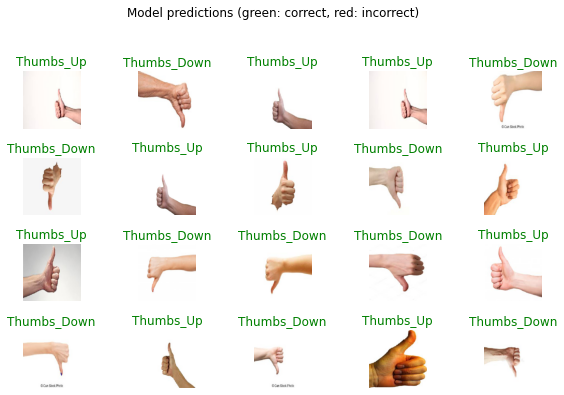

In [12]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = 'green' if predicted_ids[n] == true_label_ids[n] else 'red'
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')